(content:references:spectra_part1)=
# Stellar Spectra Part 1: *Observing Detailed Spectral Features*

***Author: Marc Hon***

Recall in [](content:references:sed_part1), we discussed the broad-band features of a stellar spectrum, described as the Spectral Energy Distribution (SED). However, it's evident a lot of structure in the spectrum is not captured from the SED alone.

In [4]:
import os
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
import pysynphot as S

from pathlib import Path
from astropy.io import fits
from matplotlib import cm
from matplotlib.colors import Normalize
from copy import copy
from astropy.modeling.models import BlackBody
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

data_folder_path = Path.cwd().resolve().parent.parent / 'ml_astro' / 'chapter2' / 'data'
os.environ['PYSYN_CDBS'] = str(data_folder_path)

plt.style.use('science')

fs = 18

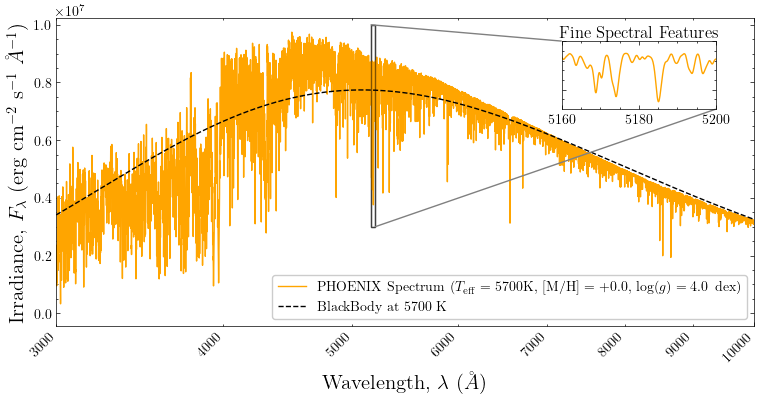

In [3]:
wav = np.arange(2000, 40000) * u.AA
temp = 5700
bb = BlackBody(temperature=temp*u.K)
flux = bb(wav).to(u.erg/u.AA/u.s/u.sr/u.cm/u.cm, equivalencies=u.spectral_density(wav)).value
observed_data = S.ArraySpectrum(wav.value, flux)

flux_conv = u.erg/u.s/(u.cm*u.cm)/u.AA
flux_conv2 = u.erg/u.s/(u.cm*u.cm)/u.cm
ph_wav_lr = fits.open(str(data_folder_path) + '/model_spectra/lte05700-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')
xlim_min, xlim_max = 2000, 40000

fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_subplot(111)

ax1.plot(ph_wav_lr[0].header['CRVAL1'] + np.arange(ph_wav_lr[0].header['NAXIS1'])*ph_wav_lr[0].header['CDELT1'],
           ph_wav_lr[0].data*flux_conv2.to(flux_conv), color='orange',
        label='PHOENIX Spectrum ($T_{\\mathrm{eff}}=5700$K, [M/H] = +0.0, $\\log(g)=4.0\\,$ dex)')
ax1.plot(observed_data.wave, observed_data.flux*np.pi, c='k', label=f'BlackBody at {temp} K', ls='--')
ax1.set_xlabel('Wavelength, $\\lambda$ ($\\AA$)', fontsize=fs-3)
ax1.set_ylabel('Irradiance, $F_\\lambda$ (erg cm$^{-2}$ s$^{-1}$ $\\AA^{-1}$)', fontsize=fs-3)
ax1.set_xlim(xlim_min, xlim_max)
ax1.get_xticklabels()
ax1.set_xscale('log')
ax1.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax1.xaxis.set_minor_formatter(mticker.ScalarFormatter())
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
for label in ax1.get_xminorticklabels():
    label.set_rotation(45)
    label.set_ha('right')
ax1.legend(frameon=1, framealpha=1)
ax1.set_xlim(3000, 10000)


ax1a = inset_axes(ax1, width="47%", height="47%", loc='center',
                  bbox_to_anchor=(0.6, 0.58, 0.47, 0.47),
                  bbox_transform=ax1.transAxes)
ax1a.plot(ph_wav_lr[0].header['CRVAL1'] + np.arange(ph_wav_lr[0].header['NAXIS1'])*ph_wav_lr[0].header['CDELT1'],
           ph_wav_lr[0].data*flux_conv2.to(flux_conv), color='orange')
ax1a.set_title('Fine Spectral Features', pad=0.1)

ax1a.set_xlim(5160, 5200)
ax1a.set_ylim(0.3e7, 1e7); ax1a.set_yticklabels([])
ax1.indicate_inset_zoom(ax1a, edgecolor="black")
mark_inset(ax1, ax1a, loc1=2, loc2=4, fc="none", ec="0.5"); plt.show()

A zoom-in of the spectrum shows fine structure from the presence of **absorption** and **emission features**. These exist because atoms and ions in a star’s atmosphere interact with light at specific wavelengths that correspond to quantized energy transitions. As light generated in the hot, dense stellar interior travels outward, it passes through cooler, lower-density layers of gas.

- **Absorption**: Atoms in these outer layers can absorb photons whose energies match the difference between two of their energy levels, removing light at those precise wavelengths and producing absorption lines in the spectrum.

- **Emission**: In rarer cases—such as in chromospheres, stellar winds, or circumstellar disks—these atoms may instead emit photons (i.e., an increase in flux) at characteristic wavelengths, leading to emission lines.

The presence, shape, and strength of these spectral features encode physical information about the star, including its effective temperature ($T_{\mathrm{eff}}$), chemical composition (global metallicity and elemental abundances), and ionization structure, which makes spectroscopy a staple tool in astrophysics.

## Variations in Stellar Spectra

Simulating stellar spectra involves solving the radiative transfer equation, informed by the equation of state of the stellar atmosphere, atomic transition probabilities, and detailed calculations of both continuum and line opacities. There exist tools to perform such calculations -- we will use the [https://github.com/AWehrhahn/SME](Spectroscopy Made Easy) code `pysme` to illustrate an example.



In [103]:
from pysme.sme import SME_Structure as SME_Struct
from pysme.abund import Abund
from pysme.linelist.vald import ValdFile
from pysme.synthesize import synthesize_spectrum, Synthesizer
from pysme.solve import solve

In general, the recipe involves defining a **line list** comprising atomic transition parameters of different elements, compiled from databases like the [Vienna Atomic Line Database (VALD)](https://vald.astro.uu.se/).

In [104]:
sme = SME_Struct()
vald = ValdFile(str(data_folder_path) + '/synth_spectra/solar.lin')
sme.linelist = vald
sme.linelist[:5]

INFO - Loading VALD file /home/marc/jupyter-book/ml_astro/chapter2/data/synth_spectra/solar.lin


/home/marc/anaconda3/lib/python3.8/site-packages/pysme/abund.py:384: RuntimeWarning: invalid value encountered in log10
  abund[1] = np.log10(abund[1]/abund[0]) + 12


WARNING - Could not find citation key: MZH
WARNING - Could not find citation key: BWT


  species     wlcent   excit  vmic  gflog  gamrad  gamqst  gamvw  lande  \
0    Cr 1  5161.7653  2.7099   2.0 -1.564    8.16   -6.06 -7.760   2.50   
1    Fe 1  5162.2720  4.1777   2.0  0.020    8.38   -3.96 -7.239   1.39   
2    Fe 1  5164.5506  4.4346   2.0 -1.360    8.15   -5.06 -7.095   1.14   
3    Fe 1  5164.9110  4.1426   2.0 -2.138    8.08   -6.02 -7.790   0.43   
4    Fe 1  5165.4098  4.2204   2.0 -0.384    8.37   -4.69 -7.510   1.33   

   depth                                          reference  nlte_flag  \
0  0.104     1 wl:K16   1 K16   1 gf:K16   1 K16   1 K16...        NaN   
1  0.705     2 wl:K14   2 K14   3 gf:FMW   2 K14   2 K14...        NaN   
2  0.313     3 wl:FMW   2 K14   3 gf:FMW   2 K14   2 K14...        NaN   
3  0.143     2 wl:K14   2 K14   2 gf:K14   2 K14   2 K14...        NaN   
4  0.644     2 wl:K14   2 K14   2 gf:K14   2 K14   2 K14...        NaN   

   atom_number  ionization  
0          1.0         1.0  
1          1.0         1.0  
2          1.0   

These contain data on the **wavelengths of transitions**, **oscillator strengths**, **excitation potentials**, and  **line broadening parameters**. These only tell us which lines exist and their intrinsic strengths per absorber, but they do not tell us the number of atoms or ions that are present in the stellar atmosphere. To do this, we need relative abundances of each element. Here, we will adopt the solar abundance pattern, shown as the following:

```{figure} images/SolarSystemAbundances.png
---
height: 350px
width: 850px
name: ss_abundances
---
Estimated abundances of the chemical elements of our Sun, calculated by measuring the relative mass fraction of different elements.
```

In [105]:
sme.abund = Abund.solar()
sme.abund

 [M/H]=0.000 applied to abundance pattern. Values below are abundances.
  H      He     Li     Be     B      C      N      O      F      Ne     Na   
 12.000 10.930  1.050  1.380  2.700  8.390  7.780  8.660  4.560  7.840  6.170
  Mg     Al     Si     P      S      Cl     Ar     K      Ca     Sc     Ti   
  7.530  6.370  7.510  5.360  7.140  5.500  6.180  5.080  6.310  3.170  4.900
  V      Cr     Mn     Fe     Co     Ni     Cu     Zn     Ga     Ge     As   
  4.000  5.640  5.390  7.450  4.920  6.230  4.210  4.600  2.880  3.580  2.290
  Se     Br     Kr     Rb     Sr     Y      Zr     Nb     Mo     Tc     Ru   
  3.330  2.560  3.250  2.600  2.920  2.210  2.580  1.420  1.920    nan  1.840
  Rh     Pd     Ag     Cd     In     Sn     Sb     Te     I      Xe     Cs   
  1.120  1.660  0.940  1.770  1.600  2.000  1.000  2.190  1.510  2.240  1.070
  Ba     La     Ce     Pr     Nd     Pm     Sm     Eu     Gd     Tb     Dy   
  2.170  1.130  1.700  0.580  1.450    nan  1.000  0.520  1.110  0.280

```{admonition} Solar abundances
The best measurements of the solar chemical composition can be found from measurements of carbonaceous chondrite, a class of meteorites that originated early in the history of the Solar System. These measurements are tabulated by studies such as [Asplund et al. 2009](https://www.annualreviews.org/content/journals/10.1146/annurev.astro.46.060407.145222).

These abundances are important because they act as a standard reference point for other elemental abundances

$$
\mathrm{[X/H]} = \log_{10}\bigg(\frac{n_X}{n_H}\bigg)_\star - \log_{10}\bigg(\frac{n_X}{n_H}\bigg)_\odot,
$$
where $\odot$ indicates a property of the Sun.

Pre-computed grids of stellar model atmospheres (e.g., PHOENIX) typically assume **scaled-solar composition**, meaning that they have the same relative proportions as the Sun, but scaled by the iron-to-hydrogen abundance [Fe/H].

For fitting the global parameters (e.g., $T_{\mathrm{eff}}$, $\log$ g, [Fe/H]) for large spectroscopic surveys of our Milky Way, it is common to also assume a solar pattern for the purpose of efficiency unless abundances are explicitly being fit.
```

In [106]:
sme.teff = 5700 # Teff
sme.logg = 4.4 # log ( g)
sme.monh = 0 # [M/H], metallicity

# Set the wavelength region to match the range of the linelist
wmin = sme.linelist.wlcent[0]
wmax = sme.linelist.wlcent[-1]
sme.wran = [wmin, wmax]

# Calculate the synthetic spectrum
sme = synthesize_spectrum(sme)

INFO - No cconfiguration file found at /home/marc/.sme/config.json, using default values instead
INFO - Don't forget to cite your sources. Use sme.citation()


`````{admonition} Exercise

Vary the global parameters ($T_{\mathrm{eff}}$, $\log$ g, [Fe/H]) for the spectrum synthesizer and observe variations in the detailed spectrum below. How does this compare with the variations in the SED observed in 
[](content:references:sed_part1)?
`````


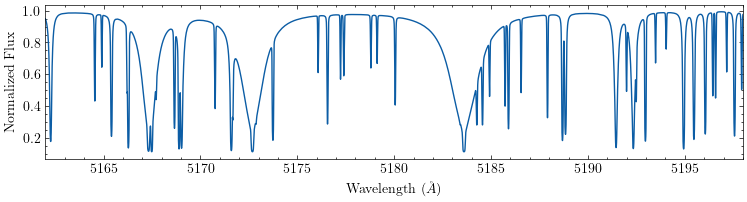

In [107]:
fig = plt.figure(figsize=(9, 2)); ax1 = fig.add_subplot(111)
ax1.plot(sme.wave.data, sme.synth.data)
ax1.set_xlim(5162, 5198)
ax1.set_xlabel('Wavelength ($\AA$)'); ax1.set_ylabel('Normalized Flux'); plt.show()

The observed dips in the stellar spectrum are caused by **absorption** from atoms and ions in the stellar atmosphere. The **depths** of these absorption features reflect how abundant the species are and how effectively they absorb light at specific wavelengths, often tracing the layers where they are most prevalent.

The depth increases approximately linearly with the number of absorbers for weak lines, but for strong (saturated) lines, an increase in the number of absorbers mainly serves to broaden the wings of the spectral lines instead. The relationship between the strength of a spectral line with the number of absorbers is described by a [curve of growth](https://en.wikipedia.org/wiki/Curve_of_growth).

In the following, several notable elements are highlighted in the synthetic spectrum:

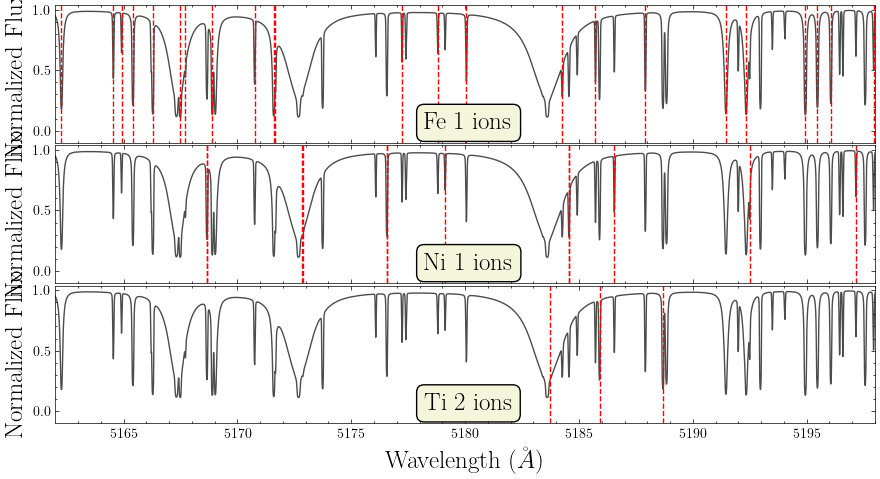

In [108]:
fig = plt.figure(figsize=(9, 5))
ax1, ax2, ax3 = fig.add_subplot(311), fig.add_subplot(312), fig.add_subplot(313)
axlist = [ax1, ax2, ax3]
elementlist = ['Fe 1', 'Ni 1', 'Ti 2']

for i, ax in enumerate(axlist):
    ax.plot(sme.wave.data, sme.synth.data, c='k', alpha=0.7)
    ax.set_xlim(5162, 5198)
    ax.set_ylim(-0.1, None)
    ax.set_ylabel('Normalized Flux', fontsize=fs)
    if i == (len(axlist) - 1):
        ax.set_xlabel('Wavelength ($\AA$)', fontsize=fs)
    else:
        ax.set_xticklabels([])
        
    for w in sme.linelist[sme.linelist.species == elementlist[i]].wlcent:
        ax.axvline(x=w,ls='--', c='r')
    
    ax.text(x=0.45, y=0.1, transform=ax.transAxes, size=fs , s=elementlist[i] + ' ions',\
    bbox=dict(facecolor='beige', edgecolor='black',
              boxstyle='round,pad=0.3', alpha=1.0))
plt.tight_layout(h_pad=0.1); plt.show()

## Observations of Real Spectra

Thus far, we have been working with synthetic spectra—models generated under idealized assumptions, where physical conditions are precisely known and instrumental imperfections are absent. These theoretical spectra are smooth, noise-free, and continuous across wavelength, which gives a clean view of atomic and molecular features.

However, real stellar spectra collected from telescopes and spectrographs are subject to limitations of the observing instrument and environmental conditions. These include:

- Lower spectral resolution 
- The presence of noise, which lowers the signal-to-noise ratio (SNR)
- An incomplete or irregular wavelength coverage
- Systematic differences between instruments

First, let's examine some real stellar spectra. We will use a library of high resolution (R$\sim$55,000), high signal-to-noise (>100) spectra taken with the HIRES instrument on the Keck Observatory in Hawaii by the [California Planet Search](https://exoplanets.caltech.edu/cps/).

In [15]:
specmatch_data = np.load(str(data_folder_path) + '/specmatch_lib_spectra_train.npz')
specmatch_data_test = np.load(str(data_folder_path) + '/specmatch_lib_spectra_test.npz')

specmatch_lib = pd.read_csv(str(data_folder_path) + '/specmatch_lib_params_train.csv')
specmatch_lib_test = pd.read_csv(str(data_folder_path) + '/specmatch_lib_params_test.csv')

specmatch_spectra = specmatch_data['library_spectra']; specmatch_wav = specmatch_data['wav']
specmatch_spectra_test = specmatch_data_test['library_spectra']; specmatch_wav_test = specmatch_data['wav']

specmatch_lib

,lib_index,cps_name,lib_obs,source,source_name,Teff,u_Teff,radius,u_radius,logg,...,mass,u_mass,age,u_age,vsini,Plx,u_Plx,Plx_source,Vmag,snr
0,0,100623,rj06.1125,Brewer,HD 100623,5140.2,60.0,0.720,0.040,4.558,...,0.75,0.04,9.81,0.50,0.29,104.59,0.40,Gaia,5.980,175.723
1,1,101904,rj20.1313,Brewer,HD 101904,5883.2,60.0,1.540,0.190,4.104,...,1.12,0.09,9.80,0.11,2.46,12.51,0.26,Gaia,8.200,149.859
2,2,102195,rj15.2019,Brewer,HD 102195,5276.8,60.0,0.850,0.050,4.503,...,0.89,0.04,9.74,0.49,2.82,34.02,0.26,Gaia,8.060,174.120
3,3,102444,rj72.386,Brewer,HD 102444,5227.3,60.0,2.670,0.390,3.600,...,1.02,0.21,9.98,0.27,2.79,8.48,0.24,Gaia,7.950,152.778
4,4,102956,rj72.98,Brewer,HD 102956,4985.1,60.0,3.790,0.470,3.385,...,1.30,0.15,9.70,0.17,1.49,8.13,0.24,Gaia,7.851,154.959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,397,GL702A,rj187.474,Von Braun,GJ702A,5407.0,52.0,0.831,0.004,4.560,...,0.92,0.03,9.30,0.35,NaN,NaN,NaN,NaN,4.123,163.889
396,398,GL702B,rj187.477,Von Braun,GJ702B,4393.0,149.0,0.670,0.009,4.640,...,0.71,0.03,9.61,0.52,NaN,NaN,NaN,NaN,7.160,166.148
397,399,GL876,rj45.596,Von Braun,GJ876,3129.0,19.0,0.376,0.006,4.880,...,0.35,0.01,10.09,0.41,NaN,214.05,0.97,Gaia,10.192,172.906
398,400,HIP57087,rj06.1488,Von Braun,GJ436,3416.0,53.0,0.455,0.018,4.830,...,0.45,0.03,9.62,0.52,NaN,102.58,0.31,Gaia,10.613,112.768


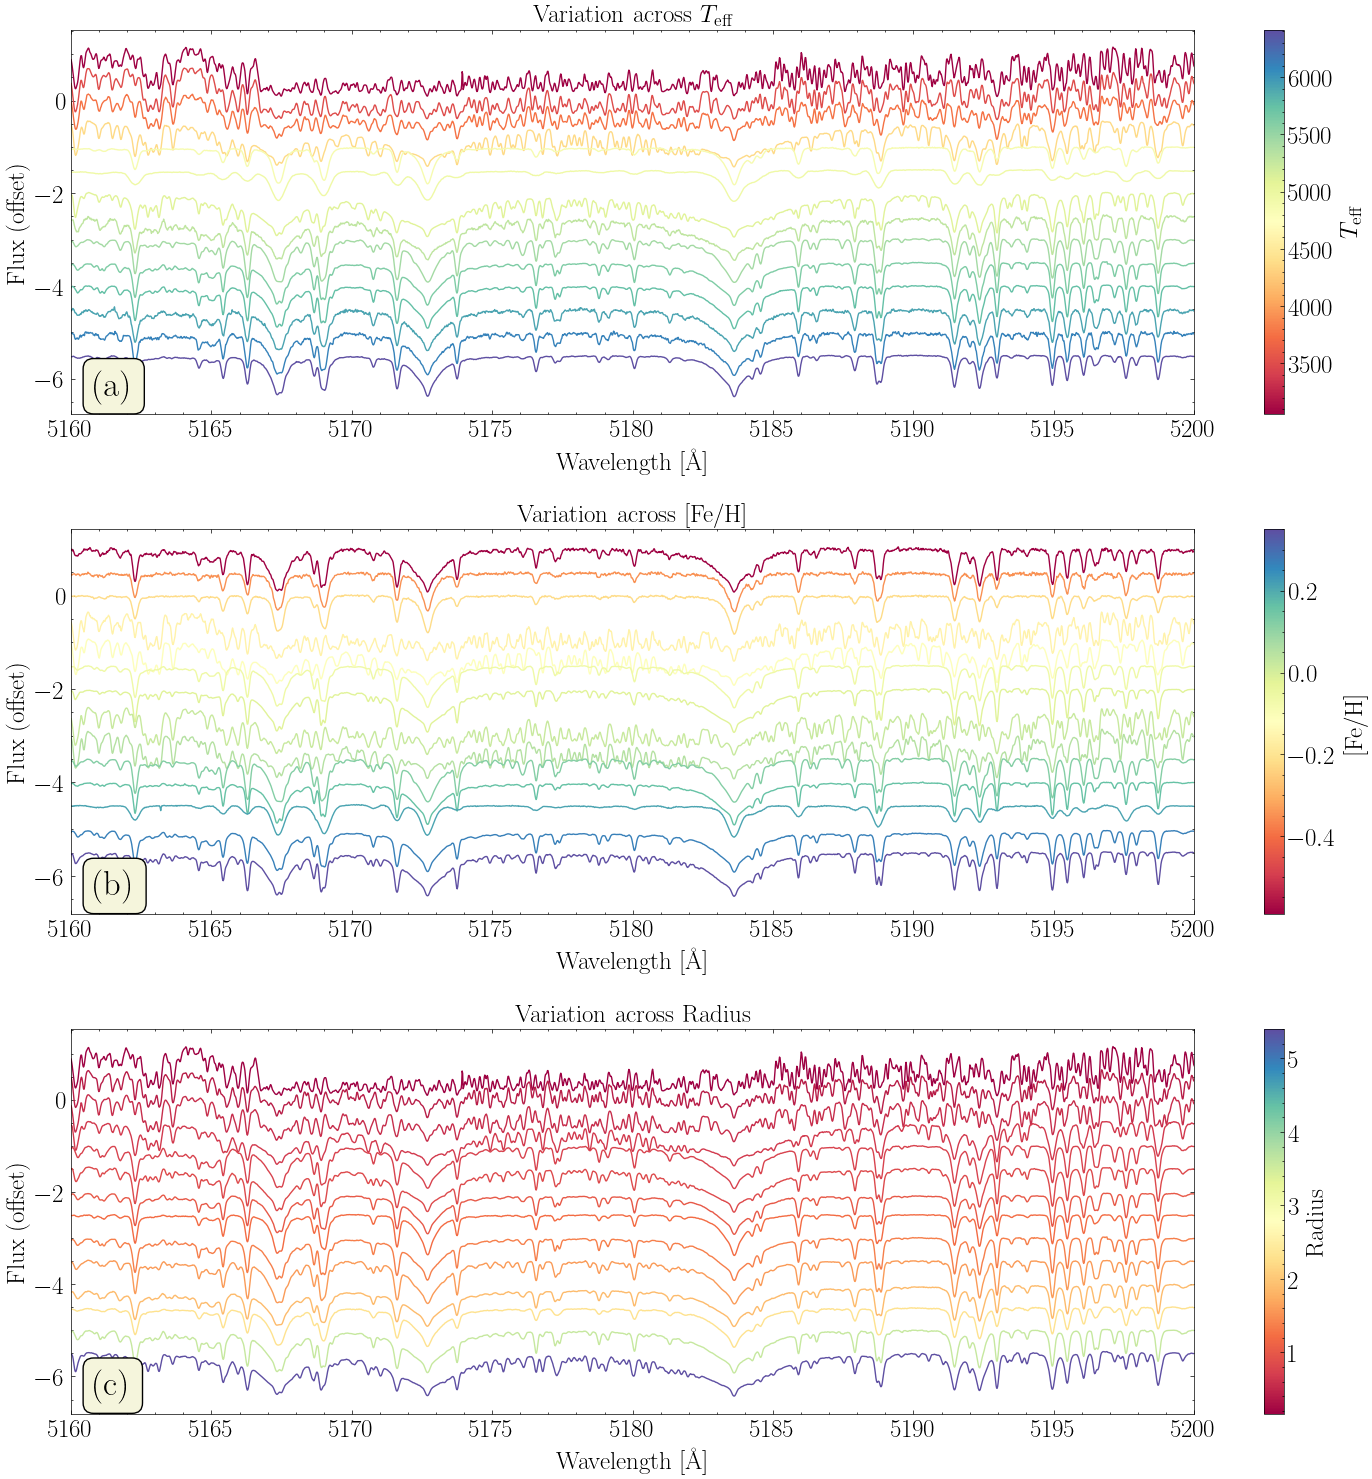

In [4]:
fig = plt.figure(figsize=(15, 15))
ax1, ax2, ax3 = fig.add_subplot(311), fig.add_subplot(312), fig.add_subplot(313)
axlist = [ax1,ax2, ax3]

s_params = ['Teff', 'feh', 'radius']
s_string = ['$T_{\\mathrm{eff}}$', '[Fe/H]', 'Radius']
lbl = ['(a)', '(b)', '(c)']

cmap = plt.cm.Spectral 

for ax,param_name, param_string, lb in zip(axlist, s_params, s_string, lbl):
    selected_indices = specmatch_lib.sort_values(by=param_name).lib_index[::30].values
    num_spectra = len(selected_indices)
    params = specmatch_lib.sort_values(by=param_name)[param_name][::30].values
    norm = colors.Normalize(vmin=params.min(), vmax=params.max())

    for i, (idx, p) in enumerate(zip(selected_indices, params)):
        color = cmap(norm(p))
        ax.plot(specmatch_wav,
                 specmatch_spectra[idx, :] - i * 0.5,
                 color=color)

    ax.set_xlabel('Wavelength [Å]', fontsize=fs)
    ax.set_ylabel('Flux (offset)', fontsize=fs)
    ax.set_title(f'Variation across {param_string}', fontsize=fs)
    ax.set_xlim(5160, 5200); ax.tick_params(axis='both', labelsize=fs)
    ax.text(x=0.02, y=0.05, s=lb, transform=ax.transAxes, fontsize=fs+7, fontweight='bold',\
            bbox=dict(facecolor='beige', edgecolor='black',\
              boxstyle='round,pad=0.3', alpha=1.0))
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label(param_string, fontsize=fs)
    cbar.ax.tick_params(labelsize=fs)
plt.tight_layout(h_pad=2)

The same 14 spectra are shown across panels (a)-(c). Here, we observe that specific morphological changes in the spectra correspond to variations in more than one global stellar parameter. This suggests that these parameters **are not independent but are instead correlated**, as expected from stellar evolutionary theory. Along the same vein, this indicates that the global parameters of stars are encoded in the morphology in spectra.



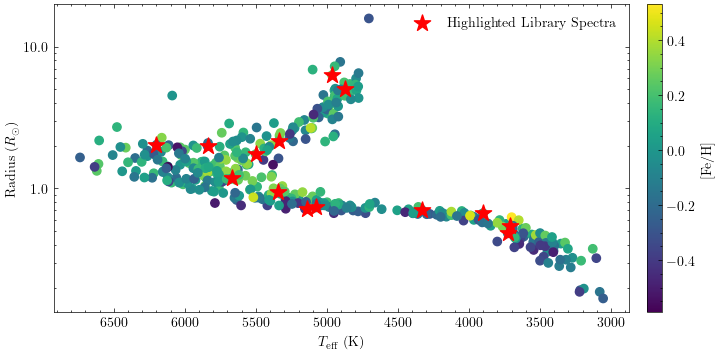

In [36]:
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_subplot(111)

im1 = ax1.scatter(specmatch_lib.Teff, specmatch_lib.radius, c=specmatch_lib.feh)
ax1.scatter(specmatch_lib.Teff[::30], specmatch_lib.radius[::30], c='r', s=150, marker='*',
           label='Highlighted Library Spectra')
ax1.invert_xaxis()
ax1.set_yscale('log')
ax1.set_ylabel('Radius ($R_{\\odot}$)')
ax1.set_xlabel('$T_{\\mathrm{eff}}$ (K)')
ax1.yaxis.set_major_formatter(mticker.ScalarFormatter())
cb1 = fig.colorbar(im1, ax=ax1, label='[Fe/H]', pad=0.025)
ax1.legend(); plt.show()

## Matching Spectra

Suppose we are given the following set of spectra below. How do we determine the global properties of these three stars based on the empirical library of spectra at hand?

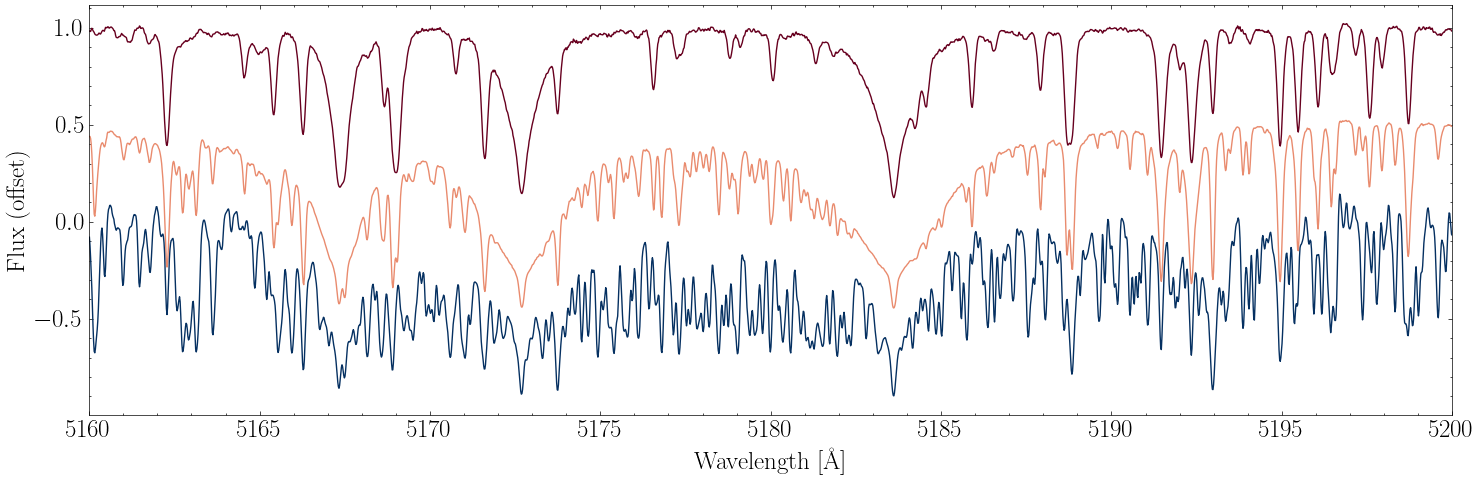

In [16]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)

cmap = plt.cm.RdBu 
norm = colors.Normalize(vmin=specmatch_lib_test.lib_index.min(), vmax=specmatch_lib_test.lib_index.max())

for i, (idx, p) in enumerate(zip(range(len(specmatch_lib_test)), specmatch_lib_test.lib_index)):
    color = cmap(norm(p))
    ax.plot(specmatch_wav_test,
             specmatch_spectra_test[idx, :] - i * 0.5,
             color=color)

ax.set_xlabel('Wavelength [Å]', fontsize=fs)
ax.set_ylabel('Flux (offset)', fontsize=fs)
ax.set_xlim(5160, 5200); ax.tick_params(axis='both', labelsize=fs)
plt.tight_layout(h_pad=2)

One way of doing this is to find the library spectrum that has an overall morphology (i.e., line profiles) that is the **most similar** to that of the new, given spectra. One way of capturing this similarity is through a  **correlation** measure, since:

- A cross-correlation measure aligns spectra before comparing them, and thus is invariant to shifts, such as from Doppler shifts

- Correlation measures focus on the shape of line profiles, instead of fixating on the similarity between raw flux values.


The [k-Shape](https://dl.acm.org/doi/10.1145/2949741.2949758) method is a time series clustering algorithm designed to capture shape-based similarities between 1D signals by defining a "shape-based distance" computed as the negative of the normalized cross-correlation (NCC) over all possible circular shifts. Using this method, we can try to identify which library entries are the most similar to our test spectra.

The [`tslearn`](https://tslearn.readthedocs.io/en/stable/) library implements handy functions to normalize 1D arrays (time series) and calculate correlation measures.

In [17]:
from tslearn.metrics.cycc import normalized_cc
from tslearn.preprocessing import TimeSeriesScalerMinMax

# First, normalize the library and test spectra to values between [0, 1]

library_spec = TimeSeriesScalerMinMax().fit_transform(specmatch_spectra).squeeze(-1)
target_spec =  TimeSeriesScalerMinMax().fit_transform(specmatch_spectra_test).squeeze(-1)

After normalizing the spectra, we will calculate a **correlation matrix**, which measures the similarity of the test spectra to each spectrum in the library.

In [18]:
corrmat = np.zeros((len(target_spec), len(library_spec)))
for i, targ in enumerate(target_spec):
    for j, libspec in enumerate(library_spec):
        corrmat[i,j] = np.max(normalized_cc(targ[None,:], libspec[None,:]))
        
best_matches = np.argmax(corrmat, 1)

`best_matches` now contains the index of the best-matching library spectrum for each test spectrum. Let's visualize!

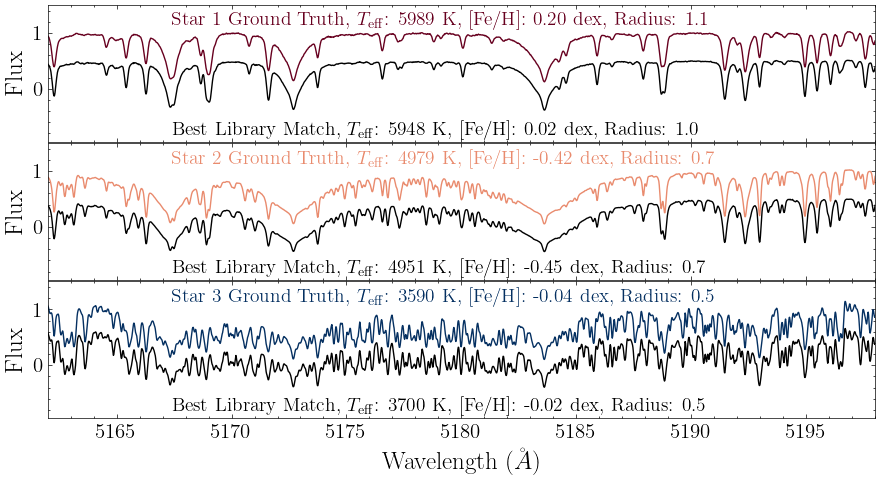

In [20]:
fig = plt.figure(figsize=(9, 5))
ax1, ax2, ax3 = fig.add_subplot(311), fig.add_subplot(312), fig.add_subplot(313)
axlist = [ax1, ax2, ax3]

for i, (ax, testspec, p) in enumerate(zip(axlist, specmatch_spectra_test,
                                          specmatch_lib_test.lib_index)):
    color = cmap(norm(p))

    ax.plot(specmatch_wav_test, testspec, c=color)
    ax.plot(specmatch_wav, specmatch_spectra[best_matches[i]] - 0.5, c='k')

    ax.set_xlim(5162, 5198)
    ax.set_ylim(-0.95, 1.5)
    ax.set_ylabel('Flux', fontsize=fs)
    if i == (len(axlist) - 1):
        ax.set_xlabel('Wavelength ($\AA$)', fontsize=fs)
    else:
        ax.set_xticklabels([])
        
#     for w in sme.linelist[sme.linelist.species == elementlist[i]].wlcent:
#         ax.axvline(x=w,ls='--', c='r')
    
    ax.text(x=0.15, y=0.85, transform=ax.transAxes, color=color,
            size=fs-4, s='Star %d Ground Truth, $T_{\mathrm{eff}}$: %d K, [Fe/H]: %.2f dex, Radius: %.1f' %(i+1, 
                                                                                             specmatch_lib_test.Teff[i],
                                                                                             specmatch_lib_test.feh[i],
                                                                                             specmatch_lib_test.radius[i]))
    
    ax.text(x=0.15, y=0.05, transform=ax.transAxes, color='k',
            size=fs-4, s='Best Library Match, $T_{\mathrm{eff}}$: %d K, [Fe/H]: %.2f dex, Radius: %.1f' %(specmatch_lib.Teff[best_matches[i]],
                                                                                             specmatch_lib.feh[best_matches[i]],
                                                                                             specmatch_lib.radius[best_matches[i]]))
        
    ax.tick_params(axis='both', labelsize=fs-3)
    
plt.tight_layout(h_pad=0.1); plt.show()

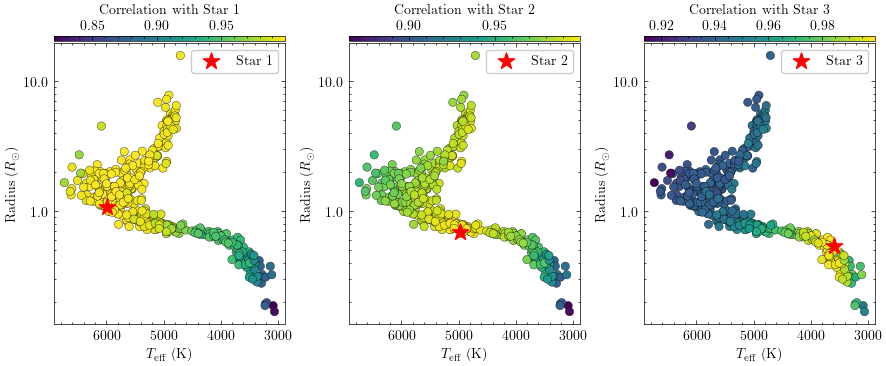

In [35]:
fig = plt.figure(figsize=(9, 4))
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)
axlist = [ax1, ax2, ax3]

for i, ax in enumerate(axlist):
    im = ax.scatter(specmatch_lib.Teff, specmatch_lib.radius, c=corrmat[i], edgecolor='k', lw=0.25)
    ax.scatter(specmatch_lib_test.Teff[i], specmatch_lib_test.radius[i], c='r', marker='*', s=150,
              label=f'Star {i+1}')
    ax.invert_xaxis()
    ax.set_yscale('log')
    ax.set_ylabel('Radius ($R_{\\odot}$)')
    ax.set_xlabel('$T_{\\mathrm{eff}}$ (K)')
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    cb1 = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.005,location='top', aspect=50,
                      label=f'Correlation with Star {i+1}')
    ax.legend(frameon=True, framealpha=1)
plt.tight_layout();plt.show()

Not bad! By comparing the ground truth for each star with the best match from the library, we see that a simple correlation metric is able to provide us with very reasonable estimates of the test star's true values.


The code [`specmatch-emp`](https://specmatch-emp.readthedocs.io/en/latest/) uses this idea of matching to an empirical library of stellar spectra observed by Keck/HIRES. The code compares an input spectrum to the library and models it as a linear combination of the most similar library spectra using least squares minimization. The weights from this combination are then used to estimate global stellar parameters such as $T_{\mathrm{eff}}$, radius, and [Fe/H] by taking a weighted average of the corresponding parameters from the selected library stars. In other words, the observed star’s properties are inferred as a weighted mean of the parameters of nearby empirical spectra in spectral space.







`````{admonition} Exercise
1. In [](content:similarity_distances), we introduced several other approaches of measuring the similarity between sequences. Determine how well these other methods find best-matching test spectra. Do these methods find a closer match to the ground truth of these test spectra?

2. Similar to 1., experiment with using a combination of **two** or more distance metrics to find a best match.

3. Discuss the limitations of using an empirical library of high-resolution spectra as a reference for assigning global stellar parameters to new observations.


`````

